In [ ]:
 #start by uploading all the required libaries

!pip install transformers
!pip install datasets
!pip install accelerate
!pip install -q -U bitsandbytes
!pip install peft
!pip install -q streamlit
!pip install sacrebleu
!pip install trl
!pip install groq -q
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!nvidia-smi

Thu Mar 13 14:58:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import torch
from datasets import load_dataset,Dataset,concatenate_datasets
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    logging,
)
from peft import LoraConfig, PeftModel,prepare_model_for_kbit_training,get_peft_model,AutoPeftModelForCausalLM
from trl import SFTTrainer, SFTConfig
import streamlit as st
from sacrebleu import corpus_bleu
import json  

## Part 1: Load dataset A

In [3]:
dataset_name = "Helsinki-NLP/opus_books"

dataset = load_dataset(dataset_name, "de-fr", split="train")
dataset = dataset.select(range(1000))


pairs = [
    {'de': ex['translation']['de'], 'fr': ex['translation']['fr']} for ex in dataset
]

json_file_path = "/content/opus_books_1000.json"
with open(json_file_path, "w", encoding="utf-8") as f:
    json.dump(pairs, f, ensure_ascii=False, indent=4)

print(f"Saved dataset to {json_file_path}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.16M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/34916 [00:00<?, ? examples/s]

Saved dataset to /content/opus_books_1000.json


In [4]:
#Splitting dataset A in 70-30 ratio
dataset_A = load_dataset("json", data_files = json_file_path, split="train")

train_test_dataset = dataset_A.train_test_split(test_size=0.30, seed=42)
train_dataset_A = train_test_dataset['train']
test_dataset_A = train_test_dataset['test']

print(train_dataset_A)
print(test_dataset_A)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['de', 'fr'],
    num_rows: 700
})
Dataset({
    features: ['de', 'fr'],
    num_rows: 300
})


In [5]:
#saving dataset A in json file
import pandas as pd
def save_dataset(dataset, filename):
    df = pd.DataFrame(dataset)
    json_path = f"{filename}.json"

    df.to_json(json_path, orient="records", force_ascii=False, indent=4)
    print(f"Saved: {json_path}")

save_dataset(train_dataset_A,'train_dataset_A')
save_dataset(test_dataset_A,'test_dataset_A')


Saved: train_dataset_A.json
Saved: test_dataset_A.json


## Part 2: Load Model A

In [6]:
from huggingface_hub import notebook_login

In [7]:
notebook_login()

In [8]:
model_name = "meta-llama/Llama-3.2-3B"

def load_model_and_tokenizer():
  compute_dtype = getattr(torch, "float16")

 #loading pre-trained model in 4 bit precision
  bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=False,
  )

    #Loading the model with quantization config
  model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
      trust_remote_code=True
)
  model.config.use_cache = False
  model.config.pretraining_tp = 1

  # Loading tokenizer for model and setting additional configs
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  tokenizer.pad_token = tokenizer.eos_token
  tokenizer.padding_side = "right"
  tokenizer.model_max_length = 1024
  return model,tokenizer


In [9]:
model_A,tokenizer = load_model_and_tokenizer()
print("Model A Loaded Successfully")


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Model A Loaded Successfully


## Part 3: Evaluate Model A

In [45]:
def evaluate_model(model, tokenizer, test_data):
    model.eval()

    predicted_translations = []
    actual_translations = []

    for i, example in enumerate(test_data):
        german_sentence = example['de']
        french_sentence = example['fr']
        german_length = len(german_sentence)
        prompt = f"Translate the given German sentence to French and return french sentence only. Do not generate additional content: \nGerman: {german_sentence} \nFrench:"

        inputs = tokenizer(prompt, return_tensors='pt').to("cuda")

        #Generating translation from model
        with torch.no_grad():
            output_tokens = model.generate(
                inputs["input_ids"],
                max_new_tokens=45,
                pad_token_id=model.config.eos_token_id
            )[0]

        output = tokenizer.decode(output_tokens, skip_special_tokens=True)
        translated_text = output.replace(prompt, "").strip()

        predicted_translations.append(translated_text)
        actual_translations.append([french_sentence])

        if i % 30 == 0:
            print(f"German Sentence: {german_sentence}")
            print(f"French Sentence: {french_sentence}")
            print(f"Model Translated: {translated_text}")

    #Computing the bleu score for the model
    bleu_score = corpus_bleu(predicted_translations, actual_translations).score
    print(f"\nBLEU Score on Test Set A: {bleu_score:.2f}\n")

    return bleu_score



In [15]:
def formatting_function(examples):
    inputs = tokenizer(examples["de"] , padding="max_length", truncation=True, max_length=256)
    targets = tokenizer(examples["fr"], padding="max_length", truncation=True, max_length=256)
    inputs["labels"] = targets["input_ids"]
    return inputs

test_data = test_dataset_A.map(formatting_function,batched=True)

In [16]:
#Evaluating Model A
bleu_score_A = evaluate_model(model_A, tokenizer, test_data)

German Sentence: »Noch eine Minute und sie wird mich als eine Heuchlerin verachten lernen,« dachte ich und bei dieser Überzeugung tobte eine namenlose Wut gegen Mrs. Reed, Brocklehurst und Compagnie durch meine Adern. Ich war keine Helen Burns.
French Sentence: «Dans une minute elle me méprisera et verra en moi une hypocrite,» pensai-je. Et alors un sentiment de rage contre Mme Reed et M. Brockelhurst alluma mon sang: je n'étais pas une Hélène Burns.
Model Translated: »Un autre moment et elle m'apprendra à la haine de la hypocrite,« pensai-je et la haine de Mrs
German Sentence: Nun, ich werde dich lehren, zwischen meinen Büchern umherzustöbern, denn sie gehören mir, und das ganze Haus gehört mir, oder wird mir wenigstens in einigen Jahren gehören. Geh und stell dich an die Thür; nicht vor den Spiegel oder die Fenster.«
French Sentence: Maintenant je vais vous apprendre à piller ainsi ma bibliothèque: car ces livres m'appartiennent, toute la maison est à moi ou le sera dans quelques ann

## Part 4: Fine-tune model A

In [17]:
#initializing lora config for fine-tuning
def initializa_lora_config(model):
    peft_config = LoraConfig(
        lora_alpha=64,
        lora_dropout=0.1,
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
            "lm_head",
        ],
        r=16,
        bias="none",
        task_type="CAUSAL_LM",
    )

    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model,peft_config)

    return model, peft_config

In [18]:
#tokenizing train and valid dataset A for fine-tuning
train_data = train_dataset_A.map(formatting_function,batched=True)


def set_training_parameters(model,tokenizer,peft_config, output_dir):
  training_arguments = SFTConfig(
      #Precision settings
    fp16=True,
    bf16=False,

      #Dataset field containing text
    dataset_text_field="text",

      #Max sequence length for input tokens
    max_seq_length=1024,

    # Batch-size per device
    per_device_train_batch_size=2,

    #Gradient-related parameter
    gradient_accumulation_steps=1,
    max_grad_norm=0.2,
      #reducing memory usage by checkpointing gradients
    gradient_checkpointing = True,

      #L2 regularization
    weight_decay = 0.001,

    # Optimizer-related parameters
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    lr_scheduler_type = "cosine",

      #Fraction of training steps for learning rate
    warmup_ratio = 0.03,
    # Epochs and saving configuration
    num_train_epochs=2,
    save_strategy="epoch",
    output_dir=output_dir,

    # Logging-related parameters
    report_to="tensorboard",
    logging_dir="./logs",
    logging_steps=100,
    seed=42
)

# Set supervised fine-tuning parameters
  trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_data,
    peft_config=peft_config,
    args=training_arguments,
)

# Train model
  trainer.train()
  return trainer

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [19]:
#fine-tuning model_B
model_B,peft_config=initializa_lora_config(model_A)
trainer=set_training_parameters(model_B,tokenizer,peft_config,"./model_B_finetuned")

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(
<ipython-input-18-07a6dffbfc88>:49: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/700 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/700 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/700 [00:00<?, ? examples/s]

Step,Training Loss
100,2.642200
200,2.524400
300,2.416800
400,2.073800
500,1.605000
600,1.572800
700,1.603500


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [ ]:
#saving model_B
trainer.model.save_pretrained("MODEL_B")
tokenizer.save_pretrained("MODEL_B")

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


('MODEL_B/tokenizer_config.json',
 'MODEL_B/special_tokens_map.json',
 'MODEL_B/tokenizer.json')

## Part 5: Evaluating Model B on test A

In [4]:
bleu_score_B = evaluate_model(model_B, tokenizer, test_data)

German Sentence: »Noch eine Minute und sie wird mich als eine Heuchlerin verachten lernen,« dachte ich und bei dieser Überzeugung tobte eine namenlose Wut gegen Mrs. Reed, Brocklehurst und Compagnie durch meine Adern. Ich war keine Helen Burns.
French Sentence: «Dans une minute elle me méprisera et verra en moi une hypocrite,» pensai-je. Et alors un sentiment de rage contre Mme Reed et M. Brockelhurst alluma mon sang: je n'étais pas une Hélène Burns.
Model Translated: »Une minute de plus, et elle m’appellera une hypocrite.« Je me préparais à devenir un être malheureux.« »Nein, ich werde es nicht ertragen,« murmelte ich und
German Sentence: Nun, ich werde dich lehren, zwischen meinen Büchern umherzustöbern, denn sie gehören mir, und das ganze Haus gehört mir, oder wird mir wenigstens in einigen Jahren gehören. Geh und stell dich an die Thür; nicht vor den Spiegel oder die Fenster.«
French Sentence: Maintenant je vais vous apprendre à piller ainsi ma bibliothèque: car ces livres m'appart

## Part 6: Dataset B Generation

In [21]:
#API key config
import os
os.environ["GROQ_API_KEY"] = "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"

In [22]:
from groq import Groq
import os
import csv
import time
import random

# Initialize Groq client
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

# Model name
model_name = "qwen-2.5-coder-32b"

import random

def create_prompt(batch_size=10):
    """Generate a dynamic prompt for diverse German-French sentence pairs."""

    #giving extra context to model so that various sentences are generated
    extra_contexts = [
        "Incorporate a variety of topics such as travel, cuisine, emotions, and everyday interactions.",
        "Ensure that the sentences are a mix of simple and complex phrases.",
        "Create sentence pairs suitable for diverse real-life scenarios.",
        "Generate sentence pairs that include idiomatic expressions.",
        "Use a mix of formal and informal sentences.",
        "Include common phrases that a traveler might need in a foreign country.",
        "Ensure the sentences are grammatically correct and natural in both languages.",
        "Make sure some sentences use polite speech while others use casual language."
    ]

    #taking 5 examples from dataset A to give reference
    df = pd.DataFrame(train_dataset_A)
    example_pairs = df.sample(n=5)

    # Selecting random context from above mentioned
    context = random.choice(extra_contexts)

    # Format example pairs
    formatted_examples = "\n".join(
        [f"German: {row['de']} | French: {row['fr']}" for _, row in example_pairs.iterrows()]
    )

    # Define the prompt
    prompt = (
        f"You are a professional linguist, creative writer, and expert translator. "
        f"Generate {batch_size} high-quality German sentences along with their precise French translations. "
        f"Ensure that the sentences are meaningful, natural, and diverse.\n\n"
        f"**Guidelines for sentence generation:**\n"
        f"- {context}\n\n"
        f"**Output Format:**\n"
        f"Each sentence pair should be structured as follows:\n"
        f"German: <sentence> | French: <translation>\n\n"
        f"**Here are 5 example sentence pairs:**\n\n"
        f"{formatted_examples}\n\n"
        f"Now generate {batch_size} more German-French sentence pairs in the same format.\n"
        f"Ensure fluency, correctness, and contextual accuracy in all translations."
    )

    return prompt

# Function to generate German-French pairs in batches
def generate_translation_pairs(batch_size=100):
    prompt = create_prompt(batch_size)
   # Generating 100 pairs per request
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {
                    "role": "system",
                    "content": prompt
                },
                {"role": "user", "content": "Generate the translation pairs now."}
            ],
            temperature=0.7,
            max_tokens=5000   # Increased to handle 100 pairs (adjust as needed)
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error generating pairs: {e}")
        return None

# Parse the response into a list of dictionaries
def parse_response(response_text):
    pairs = []
    if not response_text:
        return pairs
    lines = response_text.split("\n")
    for line in lines:
        if "German:" in line and "French:" in line:
            try:
                german = line.split("German:")[1].split("| French:")[0].strip()
                french = line.split("French:")[1].strip()
                pairs.append({"de": german, "fr": french})
            except IndexError:
                continue
    return pairs

#train dataset A contains 700 so generating 700*2 = 1400
target_pairs = 1400
batch_size = 100
translations = []
batches_needed = 14

print(f"Generating {target_pairs} German-French pairs in {batches_needed} batches...")

for i in range(batches_needed):
    print(f"Processing batch {i + 1}/{batches_needed}...")
    response = generate_translation_pairs(batch_size)
    if response:
        batch_pairs = parse_response(response)
        translations.extend(batch_pairs)
    # Respect API rate limits
    time.sleep(2)  # Adjust based on Groq's rate limit

# Trim to exactly 1,400 pairs if we overshoot
translations = translations[:target_pairs]

# Save to CSV
output_file = "dataset_B.csv"
with open(output_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["de", "fr"])
    writer.writeheader()
    writer.writerows(translations)

print(f"Generated {len(translations)} pairs. Dataset saved to {output_file}")

Generating 1400 German-French pairs in 14 batches...
Processing batch 1/14...
Processing batch 2/14...
Processing batch 3/14...
Processing batch 4/14...
Processing batch 5/14...
Processing batch 6/14...
Processing batch 7/14...
Processing batch 8/14...
Processing batch 9/14...
Processing batch 10/14...
Processing batch 11/14...
Processing batch 12/14...
Processing batch 13/14...
Processing batch 14/14...
Generated 1400 pairs. Dataset saved to dataset_B.csv


## Part 7: Model C Fine-Tuning

In [ ]:
dataset_B = load_dataset("csv",data_files="/content/dataset_B.csv",split="train")

train_dataset_B = dataset_B.select(range(1400))
save_dataset(train_dataset_B,"train_dataset_B")

Generating train split: 0 examples [00:00, ? examples/s]

In [24]:
#Loading model A again to finetune on dataset B
model_name = "meta-llama/Llama-3.2-3B"

model_A,tokenizer=load_model_and_tokenizer()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
train_data = train_dataset_B.map(formatting_function,batched=True)
test_data = test_dataset_A.map(formatting_function,batched=True)

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [26]:
model_C,peft_config=initializa_lora_config(model_A)
trainer=set_training_parameters(model_C,tokenizer,peft_config,"./model_C_finetuned")

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(
<ipython-input-18-07a6dffbfc88>:49: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/1400 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1400 [00:00<?, ? examples/s]

Step,Training Loss
100,2.025600
200,1.436000
300,1.350700
400,1.442600
500,1.287100
600,1.163500
700,1.160500
800,0.771700
900,0.769800
1000,0.746400


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [ ]:
trainer.model.save_pretrained("MODEL_C")
tokenizer.save_pretrained("MODEL_C")

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


('MODEL_C/tokenizer_config.json',
 'MODEL_C/special_tokens_map.json',
 'MODEL_C/tokenizer.json')

## Part 8: Evaluate Model C on test_Dataset_A

In [3]:
bleu_score_C = evaluate_model(model_C, tokenizer, test_data)

German Sentence: »Noch eine Minute und sie wird mich als eine Heuchlerin verachten lernen,« dachte ich und bei dieser Überzeugung tobte eine namenlose Wut gegen Mrs. Reed, Brocklehurst und Compagnie durch meine Adern. Ich war keine Helen Burns.
French Sentence: «Dans une minute elle me méprisera et verra en moi une hypocrite,» pensai-je. Et alors un sentiment de rage contre Mme Reed et M. Brockelhurst alluma mon sang: je n'étais pas une Hélène Burns.
Model Translated: »Une minute de plus et elle me détestera pour ma duplicité,« pensai-je et à cette pensée s'abattit une inconnue furieuse contre Mrs. Reed, Brock
German Sentence: Nun, ich werde dich lehren, zwischen meinen Büchern umherzustöbern, denn sie gehören mir, und das ganze Haus gehört mir, oder wird mir wenigstens in einigen Jahren gehören. Geh und stell dich an die Thür; nicht vor den Spiegel oder die Fenster.«
French Sentence: Maintenant je vais vous apprendre à piller ainsi ma bibliothèque: car ces livres m'appartiennent, tout

## Part 9: Dataset D Generation

In [37]:
df = pd.DataFrame(train_dataset_B)
print(df[['de','fr']].head(5))

                                       de  \
0    Sie saß still und starrte ins Feuer.   
1  Er erzählte ihr von seinen Abenteuern.   
2                Die Kinder lachten laut.   
3             Das Wetter war wunderschön.   
4            Sie schrieb ihm einen Brief.   

                                                  fr  
0  Elle était assise, immobile, et regardait le feu.  
1                      Il lui raconta ses aventures.  
2                          Les enfants riaient fort.  
3                         Le temps était magnifique.  
4                       Elle lui écrivit une lettre.  


In [38]:
print(train_dataset_A)
print(train_dataset_B)

Dataset({
    features: ['de', 'fr'],
    num_rows: 700
})
Dataset({
    features: ['de', 'fr'],
    num_rows: 1400
})


In [39]:
#Combining dataset A and B to create dataset C
train_dataset_C = concatenate_datasets([train_dataset_A,train_dataset_B]).shuffle(seed=42)

In [40]:
print(train_dataset_C)

Dataset({
    features: ['de', 'fr'],
    num_rows: 2100
})


In [41]:
#Saving dataset C in json
train_dataset_C.to_json("train_dataset_C.json",orient="records", force_ascii=False, indent=4)

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

465589

## Part 10: Fine-Tuned Model D

In [42]:
#fine-tuning pre-trained model to fine-tune it
model_name = "meta-llama/Llama-3.2-3B"
model_A,tokenizer=load_model_and_tokenizer()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
#formatting dataset C for fine-tuning model D
train_data = train_dataset_C.map(formatting_function,batched=True)
test_data = test_dataset_A.map(formatting_function,batched=True)

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

In [44]:
model_D,peft_config=initializa_lora_config(model_A)
trainer=set_training_parameters(model_D,tokenizer,peft_config,"./model_D_finetuned")

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(
<ipython-input-18-07a6dffbfc88>:49: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/2100 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/2100 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2100 [00:00<?, ? examples/s]

Step,Training Loss
100,2.458000
200,2.098600
300,2.050300
400,2.036500
500,1.818000
600,1.918200
700,1.865000
800,1.807700
900,1.793600
1000,1.782200


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [ ]:
#saving model D
trainer.model.save_pretrained("MODEL_D")
tokenizer.save_pretrained("MODEL_D")

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


('MODEL_D/tokenizer_config.json',
 'MODEL_D/special_tokens_map.json',
 'MODEL_D/tokenizer.json')

## Part 11: Evaluate Model D on Test Dataset A

In [4]:
bleu_score_D = evaluate_model(model_D, tokenizer, test_data)

German Sentence: »Noch eine Minute und sie wird mich als eine Heuchlerin verachten lernen,« dachte ich und bei dieser Überzeugung tobte eine namenlose Wut gegen Mrs. Reed, Brocklehurst und Compagnie durch meine Adern. Ich war keine Helen Burns.
French Sentence: «Dans une minute elle me méprisera et verra en moi une hypocrite,» pensai-je. Et alors un sentiment de rage contre Mme Reed et M. Brockelhurst alluma mon sang: je n'étais pas une Hélène Burns.
Model Translated: »Une minute de plus et elle me fera de la Heureuse.« »Die Wut gegen Brocklehurst und Mrs. Reed ist namenlos.« 
Auch eine Antwort auf meine Frage: »
German Sentence: Nun, ich werde dich lehren, zwischen meinen Büchern umherzustöbern, denn sie gehören mir, und das ganze Haus gehört mir, oder wird mir wenigstens in einigen Jahren gehören. Geh und stell dich an die Thür; nicht vor den Spiegel oder die Fenster.«
French Sentence: Maintenant je vais vous apprendre à piller ainsi ma bibliothèque: car ces livres m'appartiennent, t

## Part 12: Visualize the results of all models

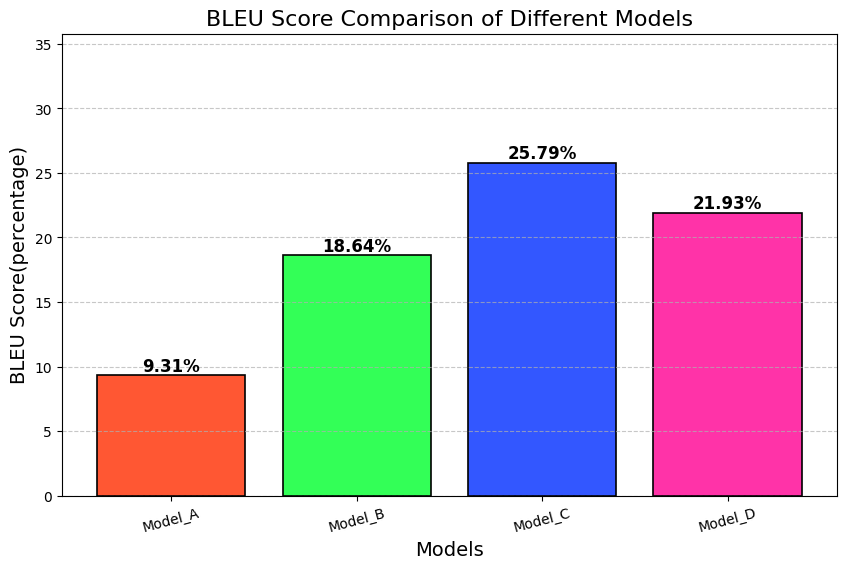

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bleu_score_A = 9.31
bleu_score_B = 18.64
bleu_score_C = 25.79
bleu_score_D = 21.93

model_names = ["Model_A","Model_B","Model_C","Model_D"]
bleu_scores = [bleu_score_A,bleu_score_B,bleu_score_C,bleu_score_D]

colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A8"] 

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, bleu_scores, color=colors, edgecolor="black", linewidth=1.2)

for bar, score in zip(bars, bleu_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{score:.2f}%",
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Models", fontsize=14)
plt.ylabel("BLEU Score(percentage)", fontsize=14)
plt.title("BLEU Score Comparison of Different Models", fontsize=16)
plt.ylim(0, max(bleu_scores) + 10)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

Showing trend of BLEU scores across all models and datasets

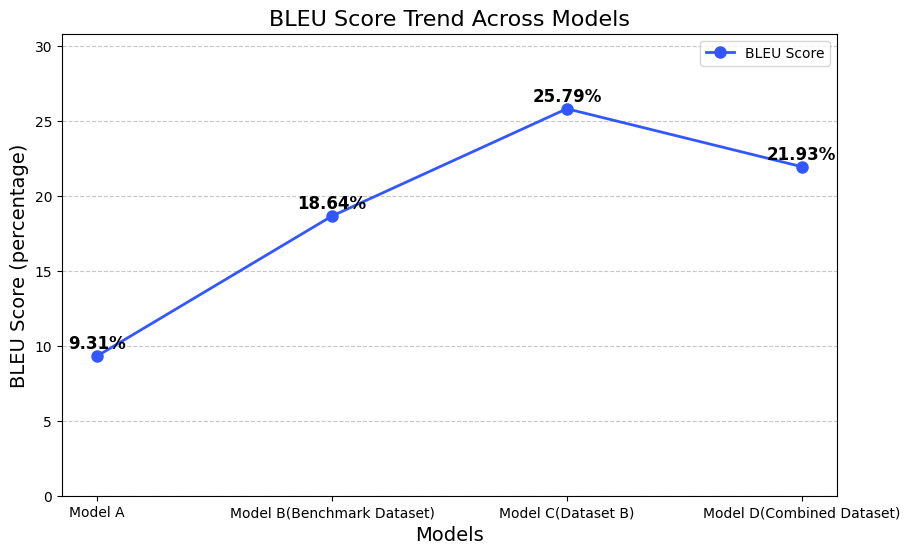

In [ ]:
import matplotlib.pyplot as plt

# BLEU Scores for Models to show the trend
bleu_scores = [bleu_score_A,bleu_score_B,bleu_score_C,bleu_score_D]
model_names = ["Model A", "Model B(Benchmark Dataset)", "Model C(Dataset B)", "Model D(Combined Dataset)"]

plt.figure(figsize=(10, 6))

plt.plot(model_names, bleu_scores, marker="o", linestyle="-", color="#3357FF", linewidth=2, markersize=8, label="BLEU Score")

for i, score in enumerate(bleu_scores):
    plt.text(i, score + 0.5, f"{score:.2f}%", ha="center", fontsize=12, fontweight="bold", color="black")

plt.xlabel("Models", fontsize=14)
plt.ylabel("BLEU Score (percentage)", fontsize=14)
plt.title("BLEU Score Trend Across Models", fontsize=16)
plt.ylim(0, max(bleu_scores) + 5)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()


## Part Stretch Goal: Interface to query the best model for translation

In [ ]:
#Writing content to python file so that gpu space is utilized optimally
content = """
import streamlit as st
import textwrap
import numpy as np
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
import torch
import re

# Load selected model
@st.cache_resource
def get_model(model_name):
    model = AutoPeftModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, load_in_4bit=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer, model

def main():
    # Set page title and icon
    st.set_page_config(page_title="German-French Translator", page_icon="🌍")

    # Add a title with custom styling
    st.markdown(
        "<h1 style='text-align: center; color: #4CAF50;'>German-French Translations</h1>",
        unsafe_allow_html=True,
    )

    # Load the model
    model_name = \"/content/MODEL_C\"
    tokenizer, model = get_model(model_name)

    # User input
    st.markdown("### Enter a German Sentence")
    user_input = st.text_area("", placeholder="Type your German sentence here...")

    # Translate button
    if st.button("Translate", key="translate_button"):
        if user_input:
            # Show a progress bar
            with st.spinner("Translating..."):
                # Prepare the prompt
                prompt = f"Translate the following German sentence to French:\\n\\nGerman: {user_input}\\nFrench:"
                input_ids = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to("cuda")

                # Generate output
                with torch.no_grad():
                    outputs = model.generate(**input_ids, max_new_tokens=50, temperature=0.7, top_p=0.6)

                # Decode and clean output
                output = tokenizer.decode(outputs[0][len(input_ids["input_ids"][0]):], skip_special_tokens=True)
                translated_text = output.strip()

            # Display the translation
            st.markdown("### French Translation")
            st.success(translated_text)
        else:
            st.warning("Please enter a German sentence to translate.")

if __name__ == "__main__":
    main()
"""

with open("translation.py", 'w') as files:
    files.write(content)

In [ ]:
#Running streamlit with localtunnel to up the interface
!streamlit run translation.py &>/content/logs.txt &
!npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.125.104.60
⠙⠹⠸⠼⠴⠦your url is: https://cuddly-llamas-melt.loca.lt
